## Graph subsampling

In [1]:
%reset -f

In [2]:
%pip install ..

Processing /home/sean/Workspaces/contact-networks
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for contact-networks, since package 'wheel' is not installed.
  Attempting uninstall: contact-networks
    Found existing installation: contact-networks 0.1.0
    Uninstalling contact-networks-0.1.0:
      Successfully uninstalled contact-networks-0.1.0
  Running setup.py install for contact-networks ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import Markdown
from contact_networks import graph_metrics, sampling_methods
from contact_networks import utils

In [4]:
colors = [
    '#E69F00',  # Soft Orange
    '#56B4E9',  # Sky Blue
    '#009E73',  # Teal Green
    '#CC79A7',  # Muted Purple
    '#F0E442',  # Golden Yellow
    '#0072B2',  # Slate Blue
    '#D55E00',  # Coral Red
]

# Set the color cycle permanently in rcParams
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

In [5]:
np.seterr(divide='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
data = utils.load_data()

In [7]:
FIG_DIR="../figures/"
TBL_DIR="../tables/"

### Helper functions

In [8]:
def compute_graph_metric(data, graph_metric, sampling_method, 
                                sized_by_nodes, sampling_ratios):
    metrics = np.zeros((6, 2 * sampling_ratios.size + 3), dtype=object)

    n_ratios = sampling_ratios.size
    row_idx = 0
    for key, item in data.items():
        adj_f2f = item['face-to-face']
        adj_cop = item['co-present']

        metrics[row_idx, 0] = key
        metrics[row_idx, 1] = graph_metric(adj_f2f)
        metrics[row_idx, n_ratios + 2] = graph_metric(adj_cop)

        if sized_by_nodes:
            size_f2f = adj_f2f.shape[0]
            size_cop = adj_cop.shape[0]
        else:
            size_f2f = np.count_nonzero(adj_f2f) / 2
            size_cop = np.count_nonzero(adj_cop) / 2

        for col_idx, ratio in enumerate(sampling_ratios):
            # compute adjacency matrices of sub-graphs
            sub_f2f = sampling_method(adj_f2f, int(ratio * size_f2f))
            sub_cop = sampling_method(adj_cop, int(ratio * size_cop))

            # remove disconnected nodes
            mask = np.any(sub_f2f != 0, axis=0)
            sub_f2f = sub_f2f[mask][:, mask]

            mask = np.any(sub_cop != 0, axis=0)
            sub_cop = sub_cop[mask][:, mask]

            # compute/store graph metric
            metrics[row_idx, col_idx + 2] = graph_metric(sub_f2f)
            metrics[row_idx, col_idx + n_ratios + 3] = graph_metric(sub_cop)

        row_idx += 1

    return metrics

#### Plotting

In [9]:
def _hist(ax, xs):
    # histogram
    hist, bins = np.histogram(xs, bins=20, density=True)
    bar = ax.bar(bins[:-1], hist, 
                 width=np.diff(bins), 
                 edgecolor='black', 
                 linewidth=0.5,
                 alpha=0.8)
    
    # hide all except the bottom spine
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    return bar

In [10]:
def plot_subfig(axes, row, sampling_ratios):
    axes = axes.ravel()
    
    n_ratios = sampling_ratios.size

    for idx in range(1, n_ratios + 2):
        _hist(
            axes[0], 
            row[idx]
        )
    axes[0].set_title(f"Face-to-face network", fontsize=10)

    for idx in range(n_ratios + 2, 2 * n_ratios + 3):
        _hist(
            axes[1], 
            row[idx]
        )
    axes[1].set_title(f"Co-presence network", fontsize=10)

In [11]:
def plot_graph_metric(data, graph_metric, sampling_method, sized_by_nodes, 
                      sampling_ratios, filename, title):
    # initialize figure with subfigs
    fig = plt.figure(layout='constrained', figsize=(10,11))
    subfigs = fig.subfigures(6,1, hspace=0.05)

    # compute graph metric
    metrics = compute_graph_metric(data, graph_metric, sampling_method,
                                   sized_by_nodes, sampling_ratios)
    
    # plot on each subfig
    for subfig, row in zip(subfigs.ravel(), metrics):
        axes = subfig.subplots(1,2, sharey=False)
        plot_subfig(axes, row, sampling_ratios)
        subfig.suptitle(f"{row[0]} dataset, |V|={data[row[0]]['face-to-face'].shape[0]}", 
                        fontsize=10, fontweight='bold')
    
    # annotate supfig
    legends = ['original'] + [f"f = {ratio}" for ratio in sampling_ratios]
    fig.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5))
    fig.suptitle(title, fontsize=12, fontweight='bold')

    # optionally save file
    if filename is not None:
        fig.savefig(os.path.join(FIG_DIR, filename), bbox_inches='tight')

    return fig


#### Tabulating

In [12]:
def tabulate_graph_metric(data, graph_metric, sampling_method, 
                          sized_by_nodes, sampling_ratios, 
                          filename, floatfmt, title):
    metrics = compute_graph_metric(data, graph_metric, sampling_method, 
                                   sized_by_nodes, sampling_ratios)

    headers = ["Dataset", "Face-to-Face"] \
            + [f"f={ratio}" for ratio in sampling_ratios] \
            + ["Co-present"] \
            + [f"f={ratio}" for ratio in sampling_ratios]

    if filename is not None:
        # create and save a LaTeX table
        tex_title = r"\caption{"+title+"}"
        tex_begin_table = r"\begin{table}[ht]"
        tex_end_table = r"\end{table}"

        tex_table = tabulate(
            metrics.tolist(),
            headers=headers,
            floatfmt=floatfmt,
            tablefmt="latex"
        )

        tex_table = f"{tex_begin_table}\n{tex_table}\n{tex_title}\n{tex_end_table}"

        with open(os.path.join(TBL_DIR,filename+".tex"), "w") as f:
            f.write(tex_table)

    # create and display a Markodown table
    md_title = title+"\n"

    md_table = tabulate(
        metrics.tolist(),
        headers=headers,
        floatfmt=floatfmt,
        tablefmt="github"
    )

    md_table = f"{md_title}\n{md_table}"

    display(Markdown(md_table))

In [13]:
sampling_ratios = np.array([0.9, 0.8, 0.7, 0.6, 0.5])

### Graph metrics

In [14]:
floatfmt = ("", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f", ".3f")

In [15]:
gms1 = [
    {
        'gm': graph_metrics.density,
        'name': "graph_metrics.density",
        'floatfmt': ()
    },
    {
        'gm': graph_metrics.average_degree,
        'name': "graph_metrics.average_degree",
        'floatfmt': (),
    },
    {
        'gm': graph_metrics.average_clustering_coefficient,
        'name': "graph_metrics.average_clustering_coefficient",
        'floatfmt': ()
    }
]
sms = [
    {
        'sm': sampling_methods.node_sampling,
        'name': "sampling_methods.node_sampling",
        'sized_by_nodes': True
    },
    {
        'sm': sampling_methods.edge_sampling,
        'name': "sampling_methods.edge_sampling",
        'sized_by_nodes': False
    },
    {
        'sm': sampling_methods.metropolis_hastings_rw,
        'name': "sampling_methods.metropolis_hastings_rw",
        'sized_by_nodes': False
    },
    {
        'sm': sampling_methods.frontier_sampling,
        'name': "sampling_methods.frontier_sampling",
        'sized_by_nodes': False
    },
    {
        'sm': sampling_methods.snowball_expansion_sampling,
        'name': "sampling_methods.snowball_expansion_sampling",
        'sized_by_nodes': True
    }
]

In [16]:
idx = 1
for gm, sm in itertools.product(gms1, sms):
    tabulate_graph_metric(data=data, 
        graph_metric=gm['gm'],
        sampling_method=sm['sm'],
        sized_by_nodes=sm['sized_by_nodes'],
        sampling_ratios=sampling_ratios, 
        filename=f"proj2_tab{idx}",
        floatfmt=floatfmt,
        title=f"`{gm['name']}` using `{sm['name']}`")
    idx += 1

`graph_metrics.density` using `sampling_methods.node_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.109 |   0.109 |   0.111 |   0.112 |   0.109 |   0.106 |        0.811 |   0.811 |   0.818 |   0.822 |   0.800 |   0.794 |
| InVS13     |          0.180 |   0.186 |   0.167 |   0.164 |   0.158 |   0.169 |        0.877 |   0.886 |   0.862 |   0.887 |   0.858 |   0.921 |
| LyonSchool |          0.285 |   0.282 |   0.271 |   0.289 |   0.307 |   0.298 |        0.912 |   0.912 |   0.900 |   0.908 |   0.911 |   0.914 |
| SFHH       |          0.118 |   0.124 |   0.120 |   0.120 |   0.114 |   0.115 |        0.908 |   0.915 |   0.909 |   0.900 |   0.917 |   0.916 |
| LH10       |          0.406 |   0.411 |   0.385 |   0.380 |   0.378 |   0.407 |        0.525 |   0.528 |   0.500 |   0.507 |   0.484 |   0.611 |
| InVS15     |          0.182 |   0.186 |   0.188 |   0.191 |   0.188 |   0.187 |        0.701 |   0.695 |   0.687 |   0.708 |   0.677 |   0.717 |

`graph_metrics.density` using `sampling_methods.edge_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.109 |   0.098 |   0.087 |   0.076 |   0.065 |   0.055 |        0.811 |   0.730 |   0.649 |   0.568 |   0.487 |   0.406 |
| InVS13     |          0.180 |   0.162 |   0.144 |   0.126 |   0.108 |   0.090 |        0.877 |   0.789 |   0.701 |   0.614 |   0.526 |   0.438 |
| LyonSchool |          0.285 |   0.257 |   0.228 |   0.200 |   0.171 |   0.143 |        0.912 |   0.821 |   0.730 |   0.638 |   0.547 |   0.456 |
| SFHH       |          0.118 |   0.106 |   0.094 |   0.083 |   0.072 |   0.060 |        0.908 |   0.817 |   0.726 |   0.636 |   0.545 |   0.454 |
| LH10       |          0.406 |   0.365 |   0.324 |   0.284 |   0.243 |   0.203 |        0.525 |   0.473 |   0.420 |   0.368 |   0.315 |   0.270 |
| InVS15     |          0.182 |   0.164 |   0.146 |   0.129 |   0.109 |   0.093 |        0.701 |   0.631 |   0.561 |   0.495 |   0.424 |   0.350 |

`graph_metrics.density` using `sampling_methods.metropolis_hastings_rw`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.109 |   0.098 |   0.087 |   0.077 |   0.066 |   0.055 |        0.811 |   0.730 |   0.649 |   0.568 |   0.487 |   0.406 |
| InVS13     |          0.180 |   0.162 |   0.144 |   0.129 |   0.108 |   0.092 |        0.877 |   0.789 |   0.701 |   0.614 |   0.526 |   0.438 |
| LyonSchool |          0.285 |   0.257 |   0.228 |   0.200 |   0.171 |   0.143 |        0.912 |   0.821 |   0.730 |   0.638 |   0.547 |   0.456 |
| SFHH       |          0.118 |   0.106 |   0.095 |   0.084 |   0.071 |   0.060 |        0.908 |   0.817 |   0.726 |   0.636 |   0.545 |   0.454 |
| LH10       |          0.406 |   0.365 |   0.324 |   0.284 |   0.243 |   0.208 |        0.525 |   0.473 |   0.420 |   0.368 |   0.324 |   0.263 |
| InVS15     |          0.182 |   0.164 |   0.147 |   0.131 |   0.111 |   0.094 |        0.701 |   0.636 |   0.566 |   0.495 |   0.424 |   0.350 |

`graph_metrics.density` using `sampling_methods.frontier_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.109 |   0.099 |   0.087 |   0.076 |   0.066 |   0.055 |        0.811 |   0.730 |   0.649 |   0.568 |   0.487 |   0.406 |
| InVS13     |          0.180 |   0.162 |   0.144 |   0.126 |   0.111 |   0.094 |        0.877 |   0.789 |   0.701 |   0.614 |   0.526 |   0.438 |
| LyonSchool |          0.285 |   0.257 |   0.228 |   0.200 |   0.171 |   0.143 |        0.912 |   0.821 |   0.730 |   0.638 |   0.547 |   0.456 |
| SFHH       |          0.118 |   0.107 |   0.095 |   0.083 |   0.072 |   0.060 |        0.908 |   0.817 |   0.726 |   0.636 |   0.545 |   0.454 |
| LH10       |          0.406 |   0.365 |   0.333 |   0.284 |   0.250 |   0.203 |        0.525 |   0.473 |   0.420 |   0.368 |   0.315 |   0.263 |
| InVS15     |          0.182 |   0.166 |   0.149 |   0.128 |   0.110 |   0.093 |        0.701 |   0.636 |   0.561 |   0.490 |   0.420 |   0.350 |

`graph_metrics.density` using `sampling_methods.snowball_expansion_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.109 |   0.113 |   0.120 |   0.124 |   0.130 |   0.140 |        0.811 |   0.806 |   0.805 |   0.806 |   0.813 |   0.818 |
| InVS13     |          0.180 |   0.191 |   0.195 |   0.218 |   0.229 |   0.219 |        0.877 |   0.866 |   0.887 |   0.899 |   0.884 |   0.866 |
| LyonSchool |          0.285 |   0.288 |   0.294 |   0.311 |   0.317 |   0.362 |        0.912 |   0.914 |   0.922 |   0.924 |   0.913 |   0.930 |
| SFHH       |          0.118 |   0.120 |   0.123 |   0.133 |   0.131 |   0.142 |        0.908 |   0.910 |   0.908 |   0.926 |   0.936 |   0.946 |
| LH10       |          0.406 |   0.441 |   0.454 |   0.515 |   0.527 |   0.619 |        0.525 |   0.561 |   0.572 |   0.660 |   0.735 |   0.786 |
| InVS15     |          0.182 |   0.179 |   0.188 |   0.192 |   0.200 |   0.203 |        0.701 |   0.699 |   0.693 |   0.689 |   0.699 |   0.711 |

`graph_metrics.average_degree` using `sampling_methods.node_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |         35.584 |  31.966 |  28.513 |  25.674 |  21.571 |  17.706 |      265.220 | 239.498 | 210.450 | 184.576 | 156.122 | 133.878 |
| InVS13     |         16.413 |  15.000 |  13.233 |  11.344 |   9.296 |   8.696 |       82.421 |  73.765 |  65.342 |  57.121 |  49.754 |  41.915 |
| LyonSchool |         68.736 |  60.949 |  55.803 |  49.231 |  42.469 |  33.802 |      219.785 | 196.894 | 175.275 | 154.817 | 131.890 | 108.926 |
| SFHH       |         47.469 |  42.304 |  37.801 |  31.004 |  26.600 |  22.600 |      365.047 | 328.464 | 294.429 | 253.220 | 221.278 | 181.771 |
| LH10       |         30.421 |  26.853 |  22.867 |  22.679 |  18.622 |  12.526 |       37.836 |  34.338 |  28.517 |  24.627 |  19.628 |  18.444 |
| InVS15     |         39.392 |  36.103 |  31.168 |  26.827 |  22.791 |  18.907 |      152.740 | 138.396 | 123.234 | 105.329 |  95.496 |  77.945 |

`graph_metrics.average_degree` using `sampling_methods.edge_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |         35.584 |  32.024 |  28.465 |  24.982 |  21.346 |  17.792 |      265.220 | 238.695 | 212.171 | 185.652 | 159.128 | 132.610 |
| InVS13     |         16.413 |  14.761 |  13.130 |  11.478 |   9.848 |   8.286 |       82.421 |  74.168 |  65.937 |  57.684 |  49.453 |  41.200 |
| LyonSchool |         68.736 |  61.860 |  54.983 |  48.107 |  41.240 |  34.364 |      219.785 | 197.802 | 175.826 | 153.843 | 131.868 | 109.893 |
| SFHH       |         47.469 |  42.720 |  37.975 |  33.308 |  28.623 |  23.850 |      365.047 | 328.541 | 292.035 | 255.529 | 219.027 | 182.521 |
| LH10       |         30.421 |  27.368 |  24.316 |  21.289 |  18.237 |  15.211 |       37.836 |  34.027 |  30.247 |  26.466 |  22.685 |  18.904 |
| InVS15     |         39.392 |  35.611 |  31.657 |  27.567 |  23.741 |  19.879 |      152.740 | 137.461 | 122.192 | 106.913 |  91.644 |  76.365 |

`graph_metrics.average_degree` using `sampling_methods.metropolis_hastings_rw`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |         35.584 |  32.024 |  28.465 |  24.982 |  21.477 |  17.902 |      265.220 | 238.695 | 212.171 | 185.652 | 159.128 | 132.610 |
| InVS13     |         16.413 |  14.761 |  13.130 |  11.478 |   9.848 |   8.472 |       82.421 |  74.168 |  65.937 |  57.684 |  49.453 |  41.200 |
| LyonSchool |         68.736 |  61.860 |  54.983 |  48.107 |  41.240 |  34.364 |      219.785 | 197.802 | 175.826 | 153.843 | 131.868 | 109.893 |
| SFHH       |         47.469 |  42.933 |  38.070 |  33.226 |  28.623 |  23.791 |      365.047 | 328.541 | 292.035 | 255.529 | 219.027 | 182.521 |
| LH10       |         30.421 |  27.368 |  24.316 |  21.289 |  18.237 |  15.211 |       37.836 |  34.500 |  30.247 |  26.833 |  22.685 |  18.904 |
| InVS15     |         39.392 |  35.611 |  31.657 |  27.694 |  23.963 |  19.787 |      152.740 | 138.092 | 122.192 | 106.913 |  91.644 |  76.365 |

`graph_metrics.average_degree` using `sampling_methods.frontier_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |         35.584 |  32.024 |  28.552 |  24.982 |  21.411 |  17.792 |      265.220 | 238.695 | 212.171 | 185.652 | 159.128 | 132.610 |
| InVS13     |         16.413 |  14.761 |  13.130 |  11.478 |  10.067 |   8.767 |       82.421 |  74.168 |  65.937 |  57.684 |  49.453 |  41.200 |
| LyonSchool |         68.736 |  61.860 |  54.983 |  48.107 |  41.240 |  34.364 |      219.785 | 197.802 | 175.826 | 153.843 | 131.868 | 109.893 |
| SFHH       |         47.469 |  42.720 |  37.975 |  33.308 |  28.695 |  24.030 |      365.047 | 328.541 | 292.035 | 255.529 | 219.027 | 182.521 |
| LH10       |         30.421 |  27.368 |  24.316 |  21.289 |  18.480 |  15.413 |       37.836 |  34.027 |  30.247 |  27.211 |  23.000 |  19.167 |
| InVS15     |         39.392 |  35.447 |  31.657 |  27.567 |  23.963 |  19.972 |      152.740 | 138.092 | 122.192 | 107.404 |  92.064 |  76.716 |

`graph_metrics.average_degree` using `sampling_methods.snowball_expansion_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |         35.584 |  33.068 |  31.211 |  28.333 |  25.469 |  23.092 |      265.220 | 236.827 | 210.176 | 183.869 | 157.847 | 133.012 |
| InVS13     |         16.413 |  15.366 |  14.027 |  13.375 |  12.364 |  10.304 |       82.421 |  72.729 |  66.526 |  58.424 |  49.579 |  40.085 |
| LyonSchool |         68.736 |  62.230 |  56.021 |  51.467 |  46.041 |  43.107 |      219.785 | 197.364 | 177.016 | 155.172 | 131.586 | 112.050 |
| SFHH       |         47.469 |  43.260 |  39.354 |  36.972 |  31.751 |  28.249 |      365.047 | 328.575 | 291.634 | 260.284 | 224.631 | 189.284 |
| LH10       |         30.421 |  29.559 |  26.800 |  25.698 |  23.200 |  22.158 |       37.836 |  35.877 |  32.621 |  32.980 |  30.791 |  27.111 |
| InVS15     |         39.392 |  34.749 |  31.954 |  28.609 |  25.615 |  21.796 |      152.740 | 136.934 | 120.617 | 104.680 |  90.382 |  76.807 |

/home/sean/Workspaces/contact-networks/.venv/lib/python3.10/site-packages/contact_networks/graph_metrics.py:77: RuntimeWarning: invalid value encountered in divide
  coefs = 2 * np.divide(np.diag(triangles), (degs * (degs - 1)))


`graph_metrics.average_clustering_coefficient` using `sampling_methods.node_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.504 |   0.503 |   0.512 |   0.508 |   0.471 |   0.485 |        0.843 |   0.841 |   0.845 |   0.839 |   0.842 |   0.857 |
| InVS13     |          0.426 |   0.423 |   0.401 |   0.415 |   0.437 |   0.363 |        0.928 |   0.933 |   0.943 |   0.924 |   0.930 |   0.922 |
| LyonSchool |          0.526 |   0.529 |   0.515 |   0.517 |   0.507 |   0.526 |        0.929 |   0.929 |   0.939 |   0.939 |   0.930 |   0.925 |
| SFHH       |          0.282 |   0.281 |   0.291 |   0.289 |   0.268 |   0.276 |        0.944 |   0.945 |   0.941 |   0.944 |   0.941 |   0.946 |
| LH10       |          0.679 |   0.677 |   0.648 |   0.628 |   0.706 |   0.502 |        0.776 |   0.763 |   0.759 |   0.799 |   0.791 |   0.766 |
| InVS15     |          0.381 |   0.385 |   0.387 |   0.377 |   0.373 |   0.400 |        0.799 |   0.808 |   0.803 |   0.809 |   0.802 |   0.783 |

`graph_metrics.average_clustering_coefficient` using `sampling_methods.edge_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.504 |   0.449 |   0.401 |   0.350 |   0.301 |   0.244 |        0.843 |   0.759 |   0.673 |   0.589 |   0.506 |   0.422 |
| InVS13     |          0.426 |   0.380 |   0.326 |   0.285 |   0.231 |   0.194 |        0.928 |   0.832 |   0.743 |   0.646 |   0.558 |   0.473 |
| LyonSchool |          0.526 |   0.471 |   0.420 |   0.369 |   0.312 |   0.267 |        0.929 |   0.836 |   0.743 |   0.651 |   0.558 |   0.464 |
| SFHH       |          0.282 |   0.252 |   0.226 |   0.198 |   0.167 |   0.138 |        0.944 |   0.849 |   0.754 |   0.660 |   0.566 |   0.472 |
| LH10       |          0.679 |   0.617 |   0.542 |   0.488 |   0.403 |   0.333 |        0.776 |   0.693 |   0.611 |   0.554 |   0.453 |   0.359 |
| InVS15     |          0.381 |   0.342 |   0.312 |   0.264 |   0.228 |   0.193 |        0.799 |   0.719 |   0.636 |   0.562 |   0.479 |   0.398 |

`graph_metrics.average_clustering_coefficient` using `sampling_methods.metropolis_hastings_rw`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.504 |   0.448 |   0.399 |   0.355 |   0.309 |   0.254 |        0.843 |   0.756 |   0.672 |   0.587 |   0.502 |   0.419 |
| InVS13     |          0.426 |   0.368 |   0.339 |   0.284 |   0.268 |   0.251 |        0.928 |   0.833 |   0.740 |   0.645 |   0.557 |   0.472 |
| LyonSchool |          0.526 |   0.466 |   0.413 |   0.366 |   0.314 |   0.272 |        0.929 |   0.835 |   0.742 |   0.652 |   0.558 |   0.465 |
| SFHH       |          0.282 |   0.230 |   0.196 |   0.169 |   0.143 |   0.112 |        0.944 |   0.849 |   0.755 |   0.660 |   0.567 |   0.472 |
| LH10       |          0.679 |   0.586 |   0.508 |   0.445 |   0.380 |   0.326 |        0.776 |   0.686 |   0.609 |   0.536 |   0.462 |   0.366 |
| InVS15     |          0.381 |   0.339 |   0.303 |   0.268 |   0.218 |   0.186 |        0.799 |   0.713 |   0.638 |   0.552 |   0.477 |   0.397 |

`graph_metrics.average_clustering_coefficient` using `sampling_methods.frontier_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.504 |   0.451 |   0.406 |   0.363 |   0.311 |   0.263 |        0.843 |   0.759 |   0.675 |   0.590 |   0.505 |   0.424 |
| InVS13     |          0.426 |   0.383 |   0.345 |   0.306 |   0.298 |   0.265 |        0.928 |   0.834 |   0.753 |   0.652 |   0.561 |   0.474 |
| LyonSchool |          0.526 |   0.474 |   0.417 |   0.375 |   0.312 |   0.276 |        0.929 |   0.836 |   0.744 |   0.651 |   0.560 |   0.469 |
| SFHH       |          0.282 |   0.257 |   0.223 |   0.198 |   0.173 |   0.144 |        0.944 |   0.849 |   0.756 |   0.662 |   0.568 |   0.474 |
| LH10       |          0.679 |   0.618 |   0.549 |   0.464 |   0.452 |   0.380 |        0.776 |   0.682 |   0.636 |   0.520 |   0.449 |   0.410 |
| InVS15     |          0.381 |   0.344 |   0.317 |   0.275 |   0.229 |   0.191 |        0.799 |   0.720 |   0.641 |   0.562 |   0.485 |   0.406 |

`graph_metrics.average_clustering_coefficient` using `sampling_methods.snowball_expansion_sampling`

| Dataset    |   Face-to-Face |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |   Co-present |   f=0.9 |   f=0.8 |   f=0.7 |   f=0.6 |   f=0.5 |
|------------|----------------|---------|---------|---------|---------|---------|--------------|---------|---------|---------|---------|---------|
| Thiers13   |          0.504 |   0.512 |   0.529 |   0.519 |   0.532 |   0.536 |        0.843 |   0.839 |   0.841 |   0.844 |   0.853 |   0.857 |
| InVS13     |          0.426 |   0.429 |   0.426 |   0.411 |   0.385 |   0.399 |        0.928 |   0.921 |   0.937 |   0.943 |   0.942 |   0.941 |
| LyonSchool |          0.526 |   0.525 |   0.526 |   0.536 |   0.558 |   0.574 |        0.929 |   0.931 |   0.938 |   0.940 |   0.931 |   0.940 |
| SFHH       |          0.282 |   0.289 |   0.301 |   0.307 |   0.316 |   0.320 |        0.944 |   0.946 |   0.946 |   0.952 |   0.956 |   0.964 |
| LH10       |          0.679 |   0.698 |   0.713 |   0.730 |   0.753 |   0.776 |        0.776 |   0.777 |   0.784 |   0.819 |   0.851 |   0.904 |
| InVS15     |          0.381 |   0.380 |   0.382 |   0.388 |   0.399 |   0.413 |        0.799 |   0.797 |   0.793 |   0.795 |   0.793 |   0.803 |

In [17]:
gms2 = [
    {
        'gm': graph_metrics.degree_distribution,
        'name': "graph_metrics.degree_distribution",
    },
    {
        'gm': graph_metrics.clustering_coefficient,
        'name': "graph_metrics.clustering_coefficient"
    }
]

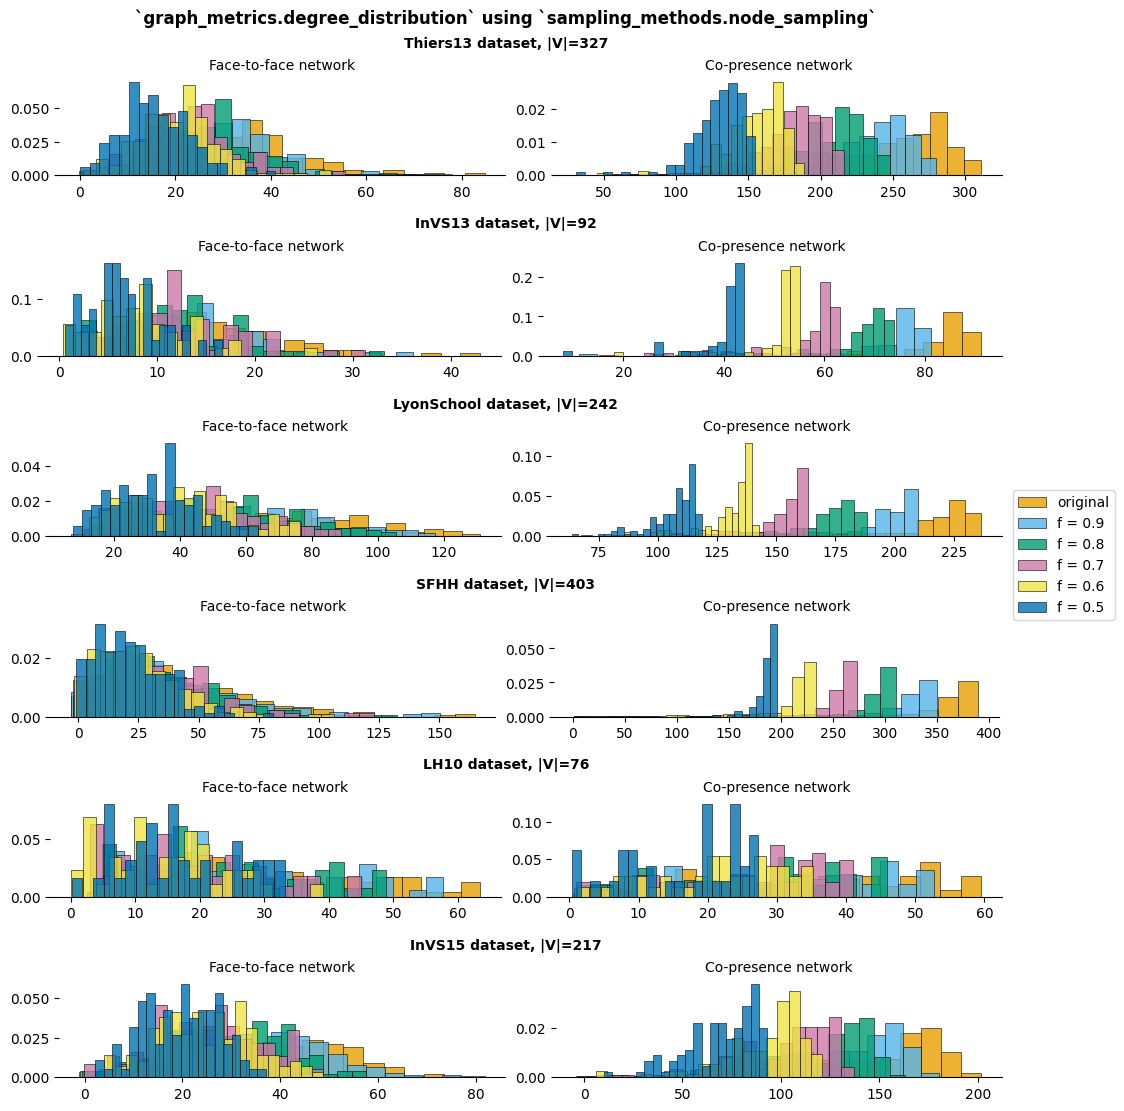

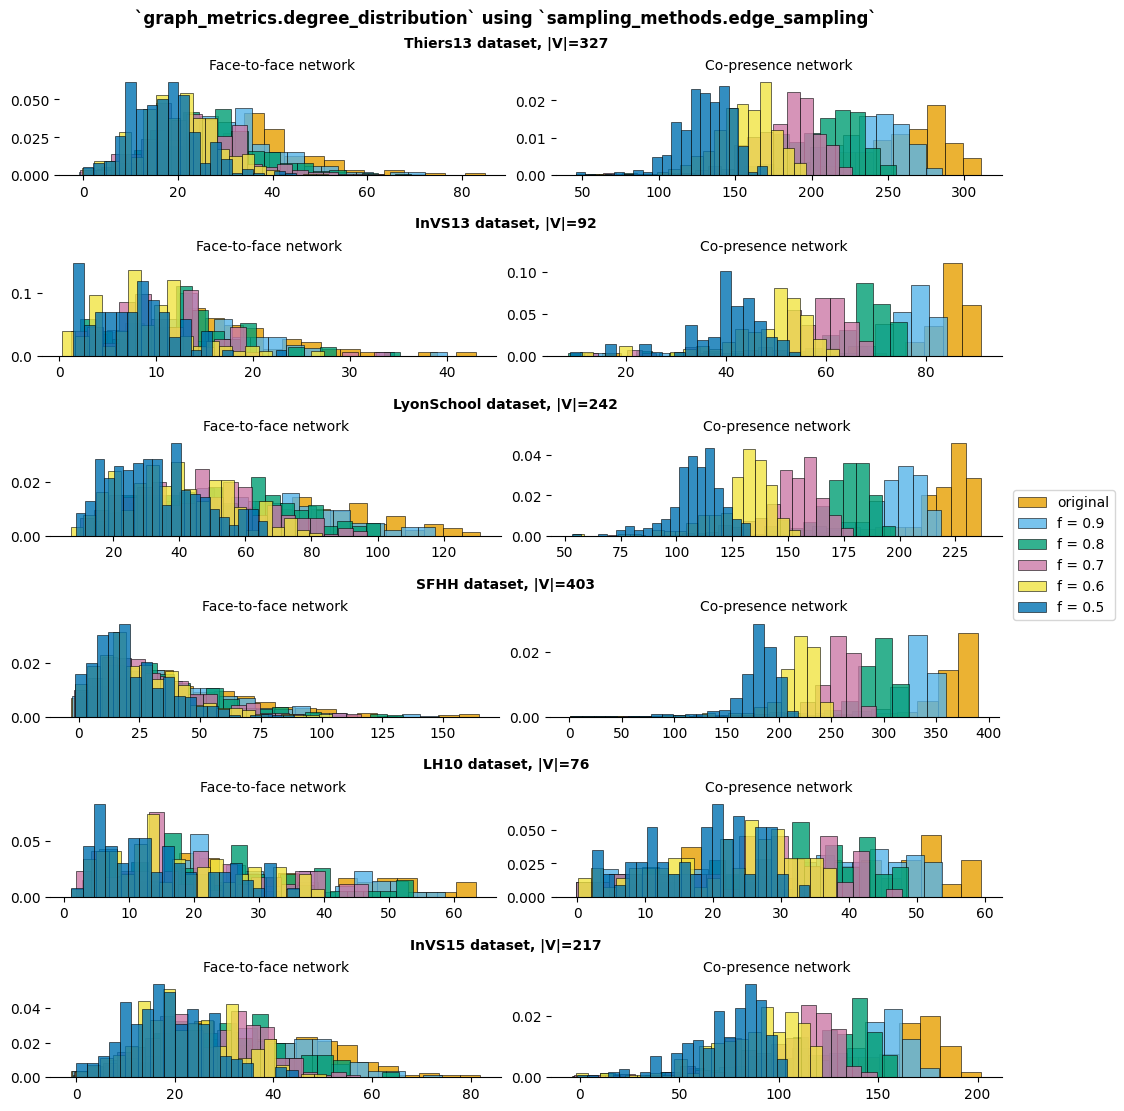

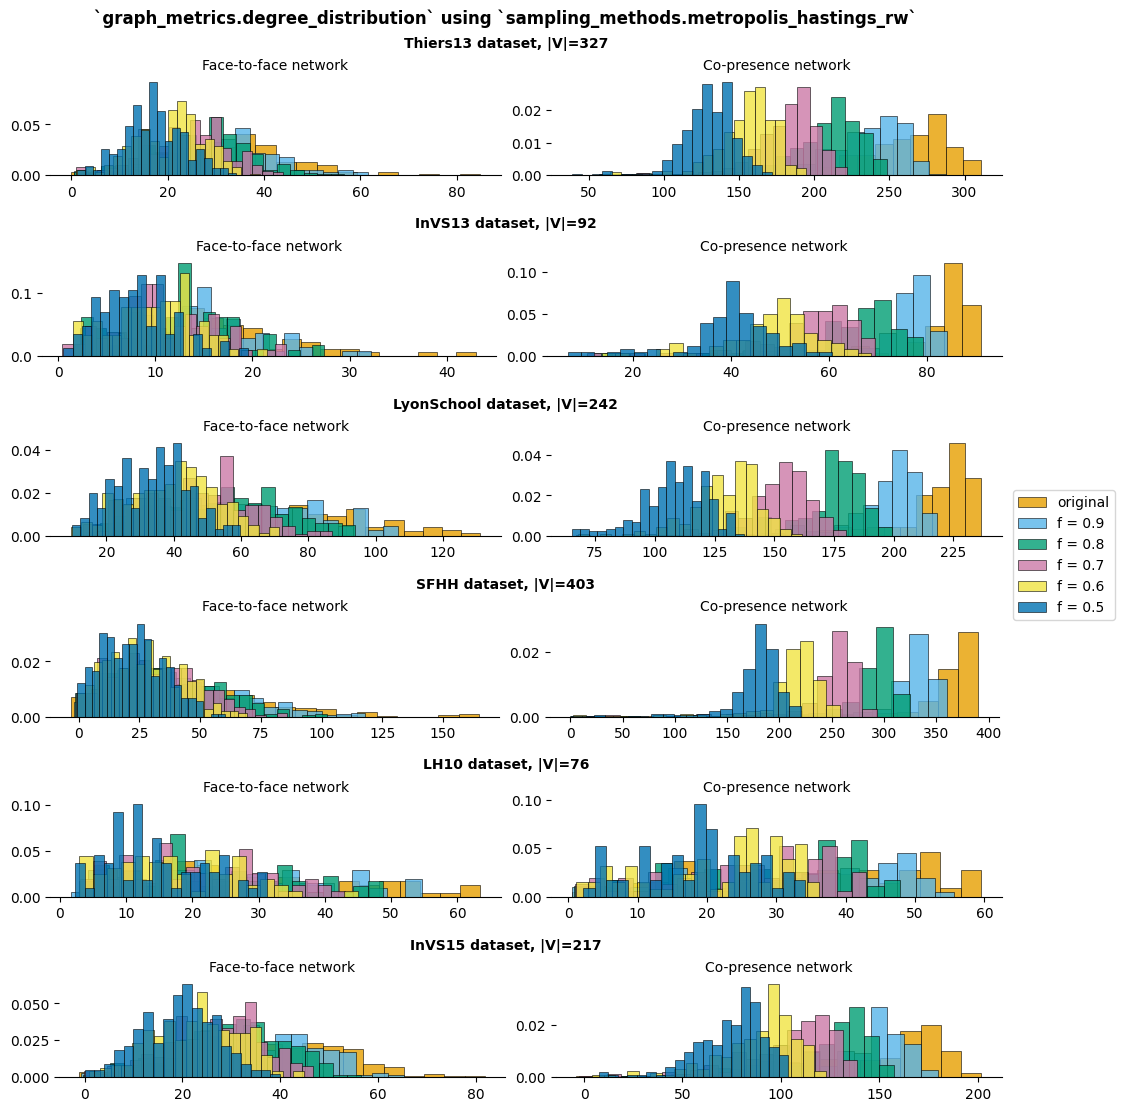

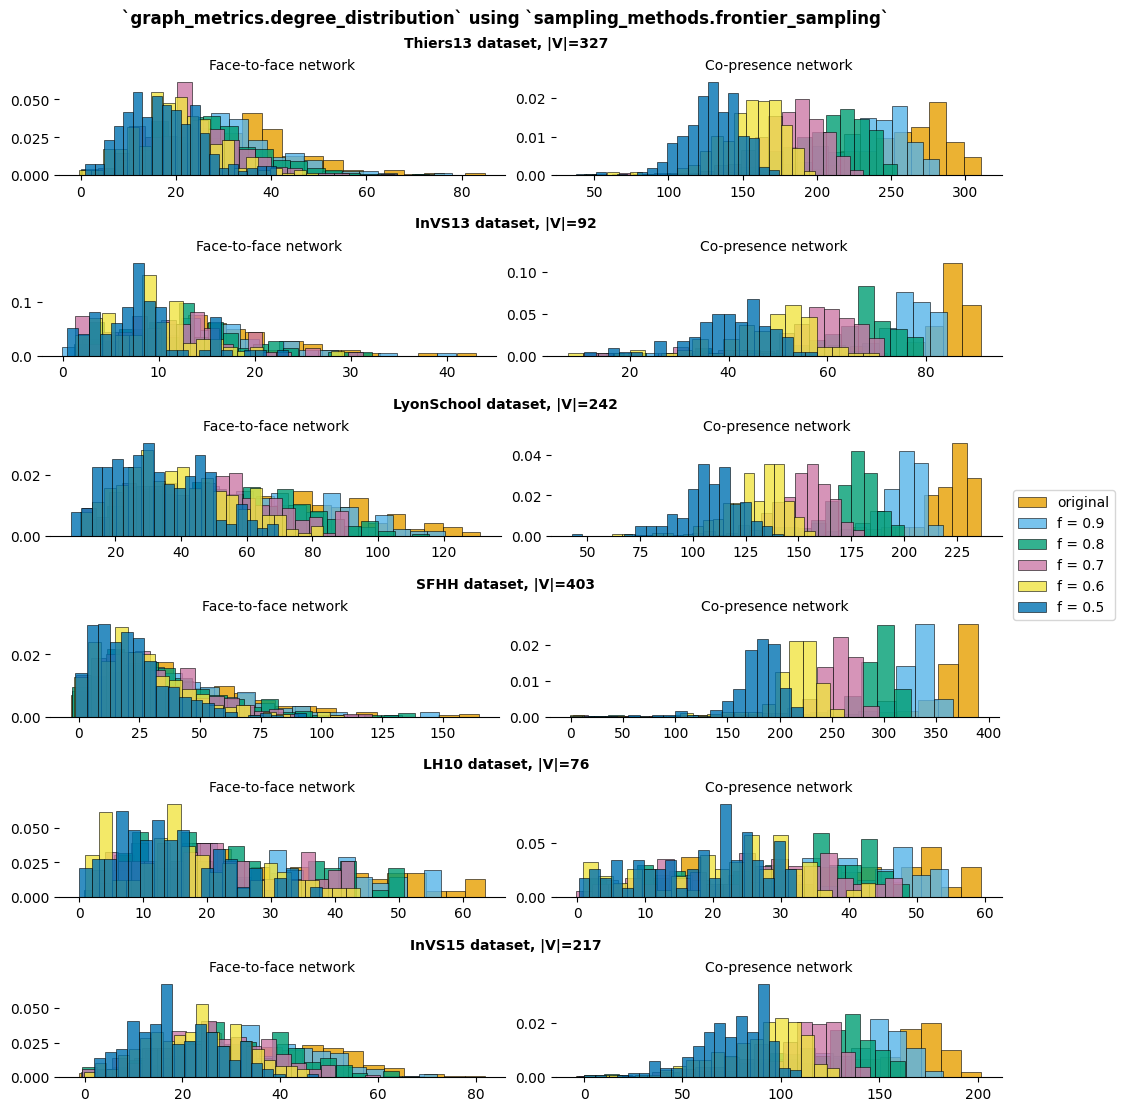

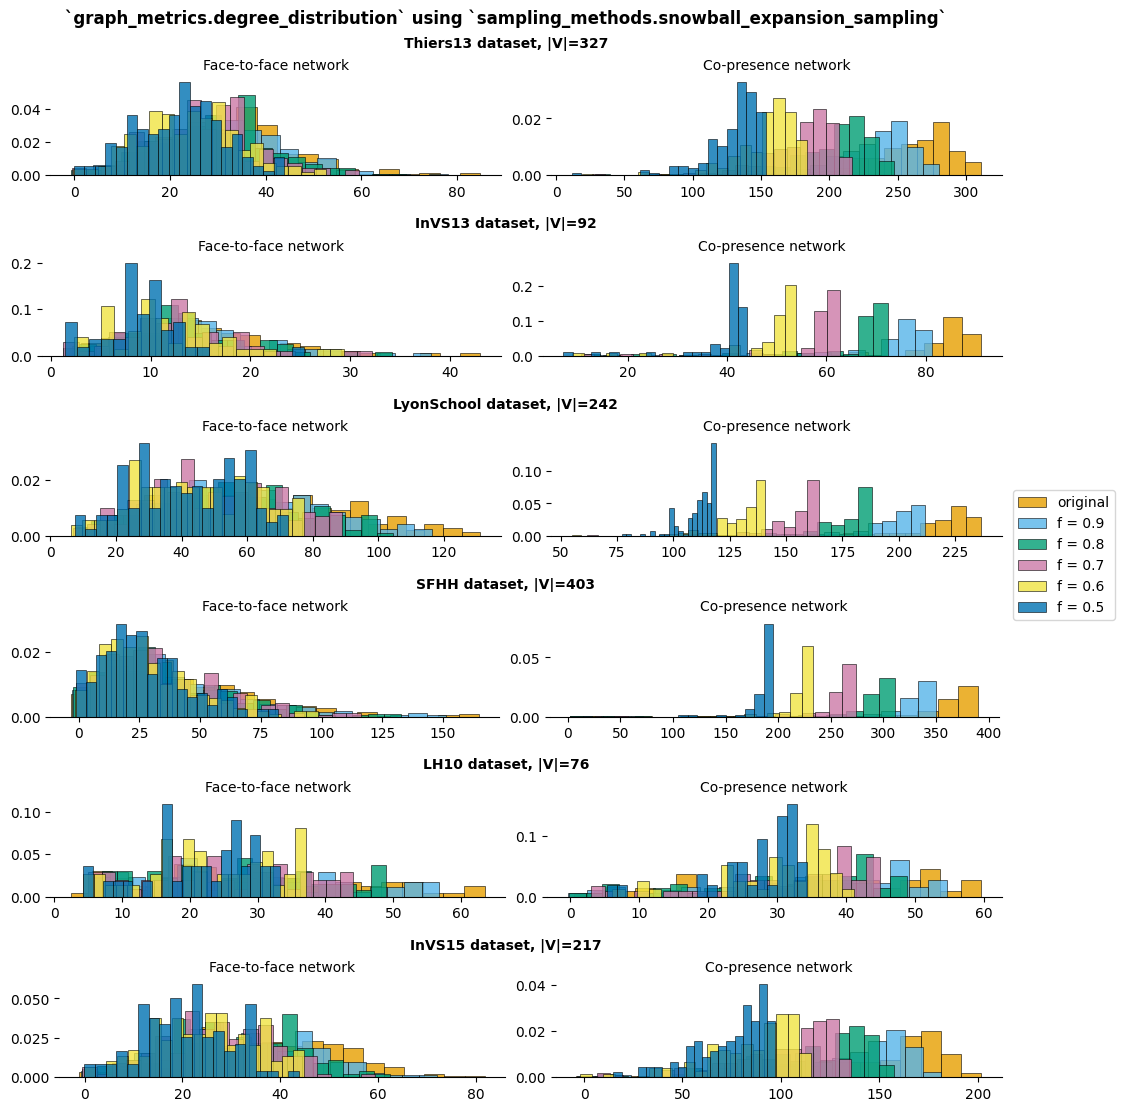

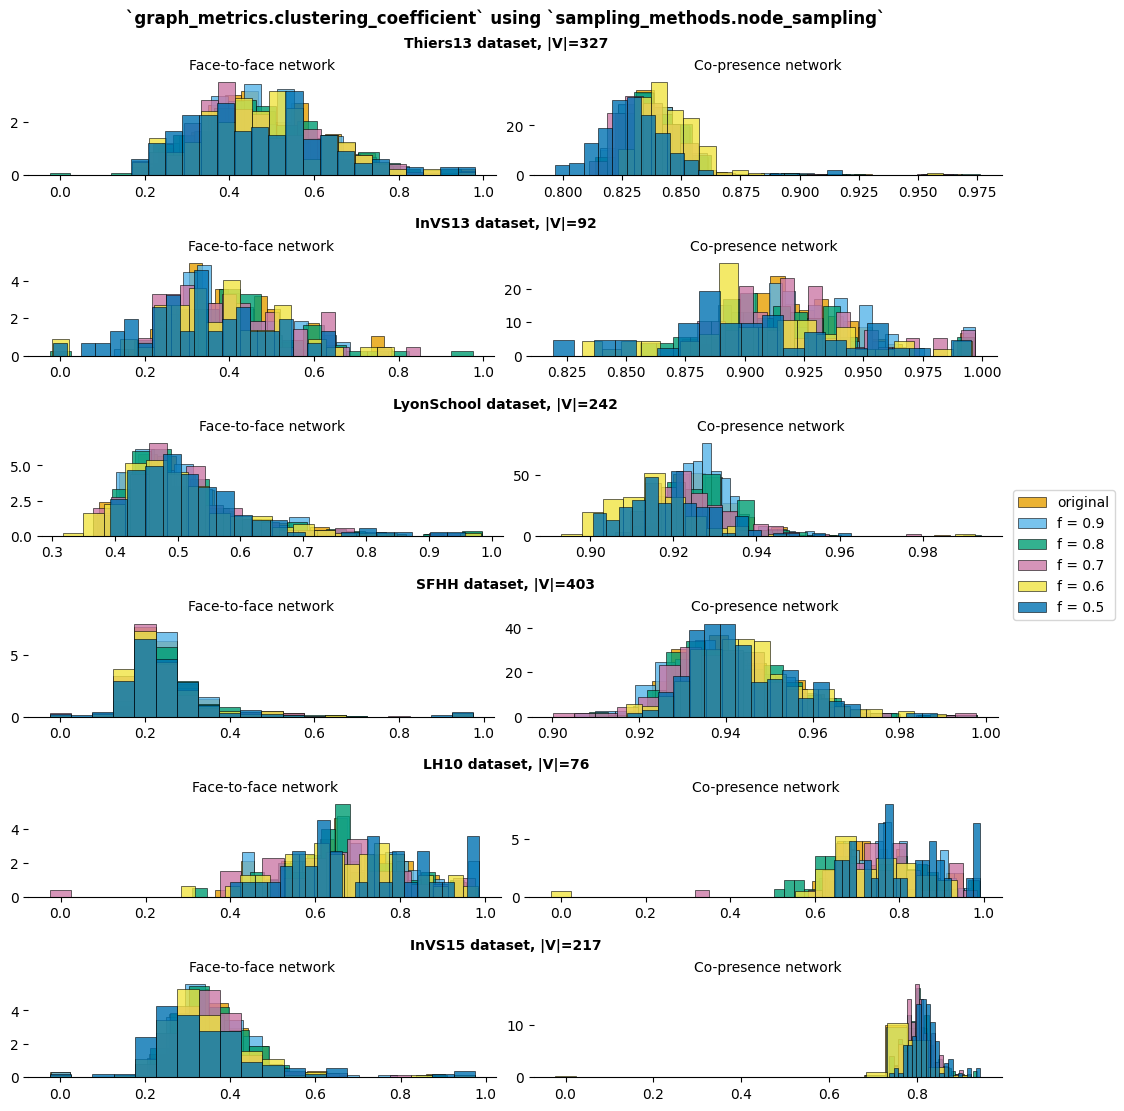

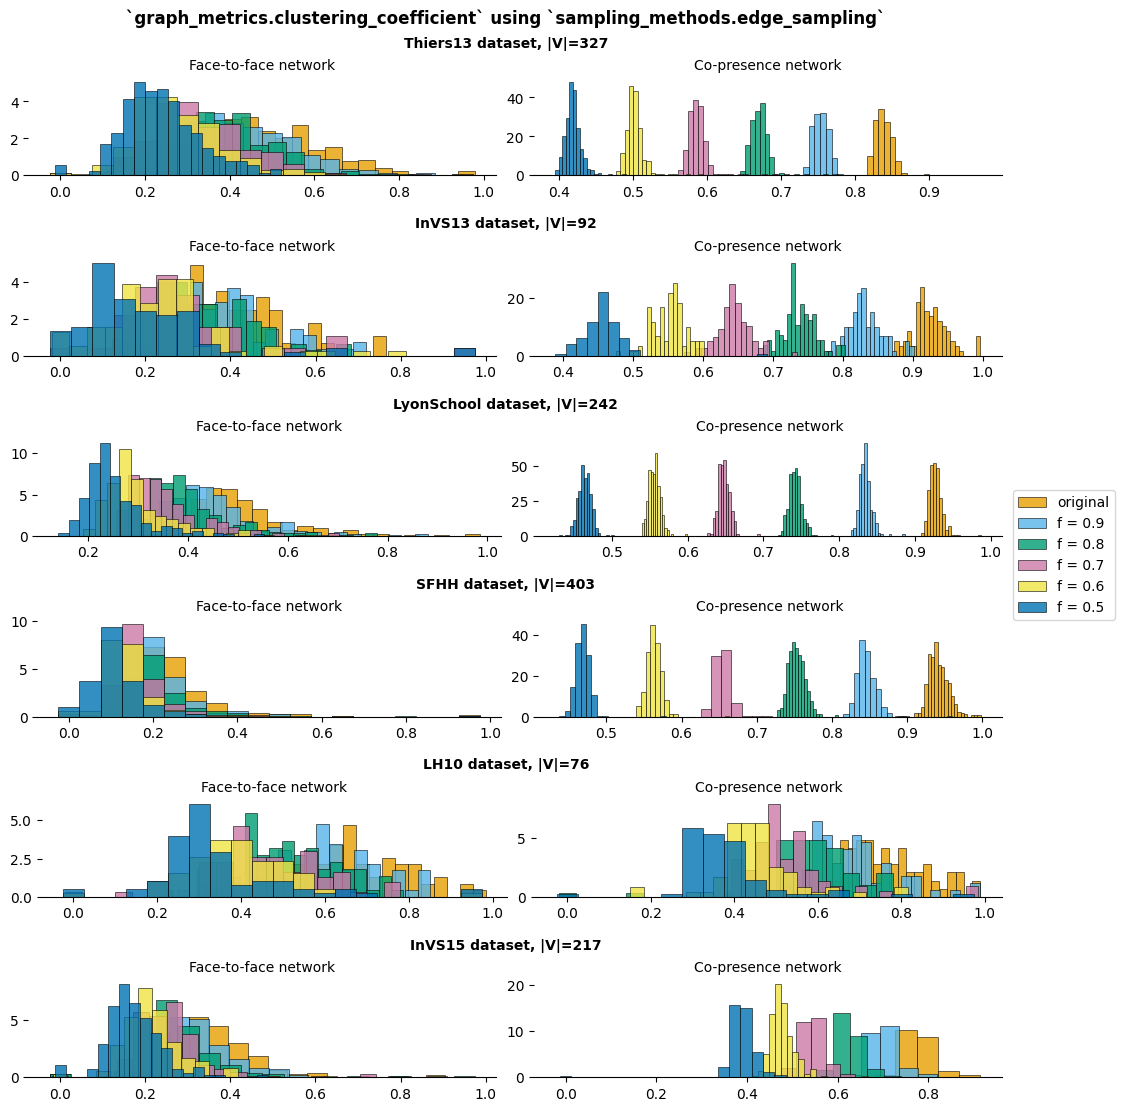

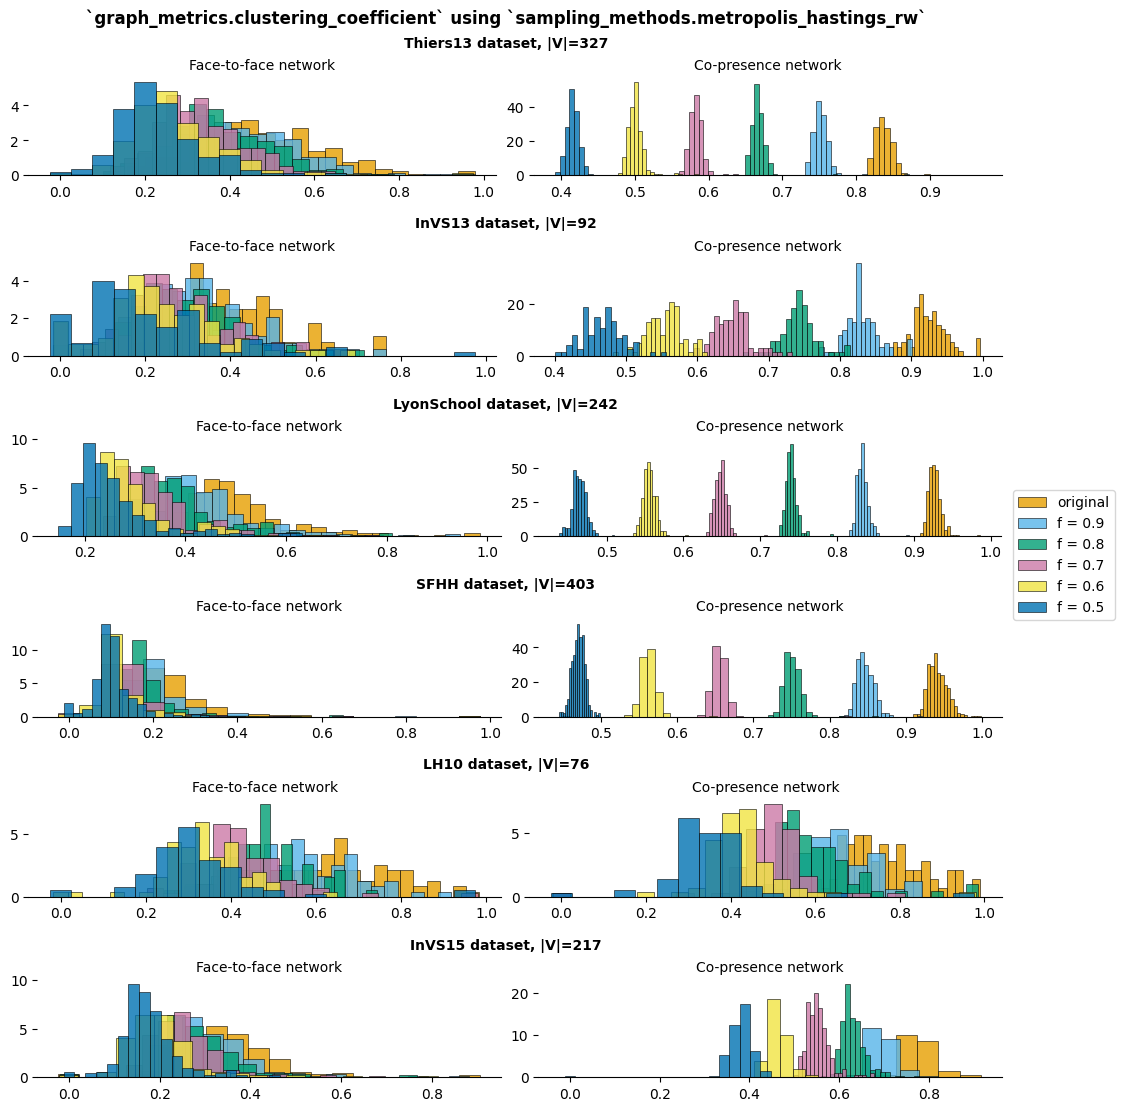

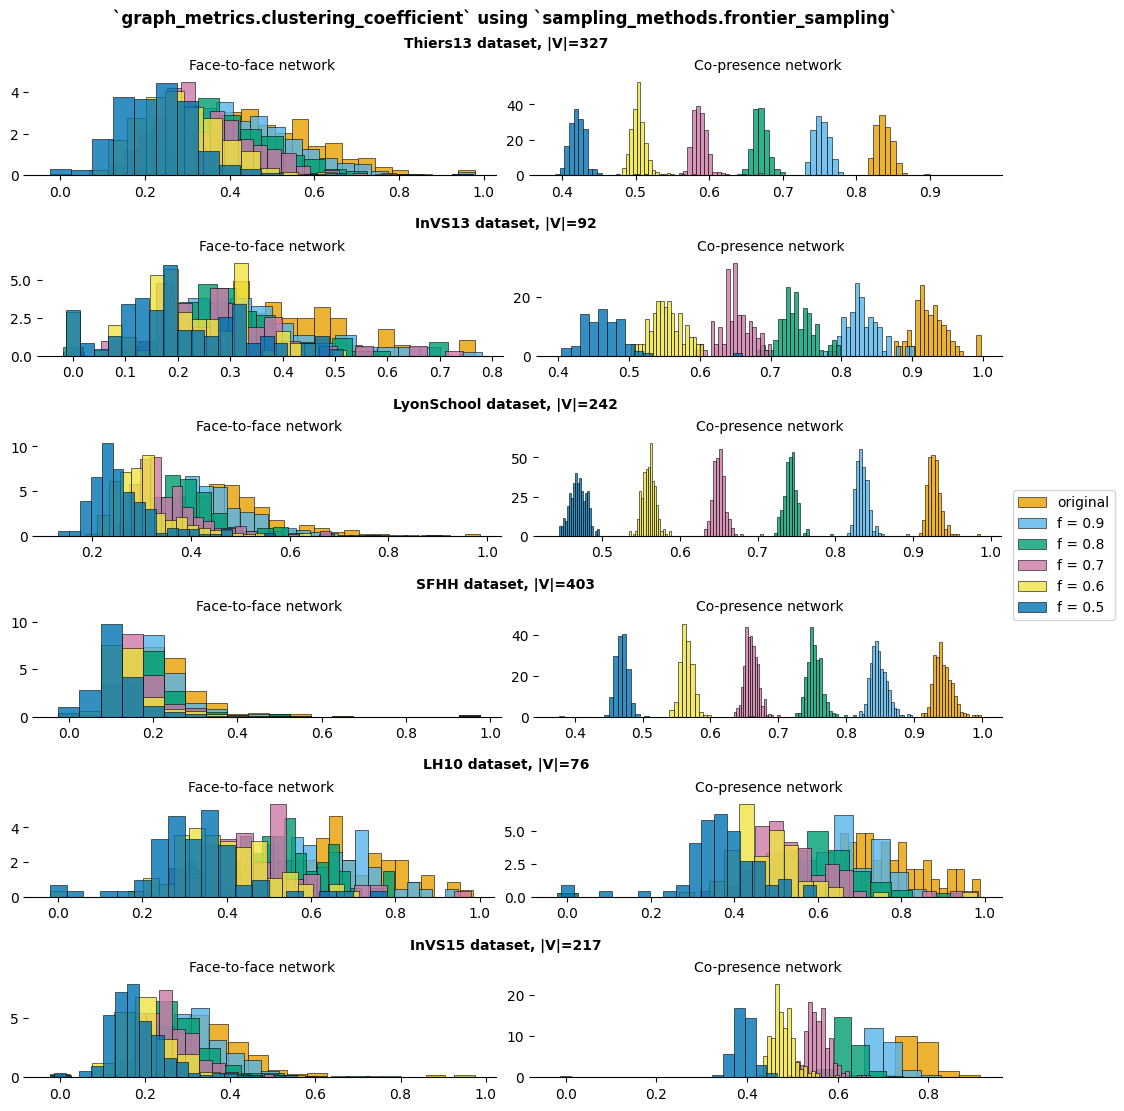

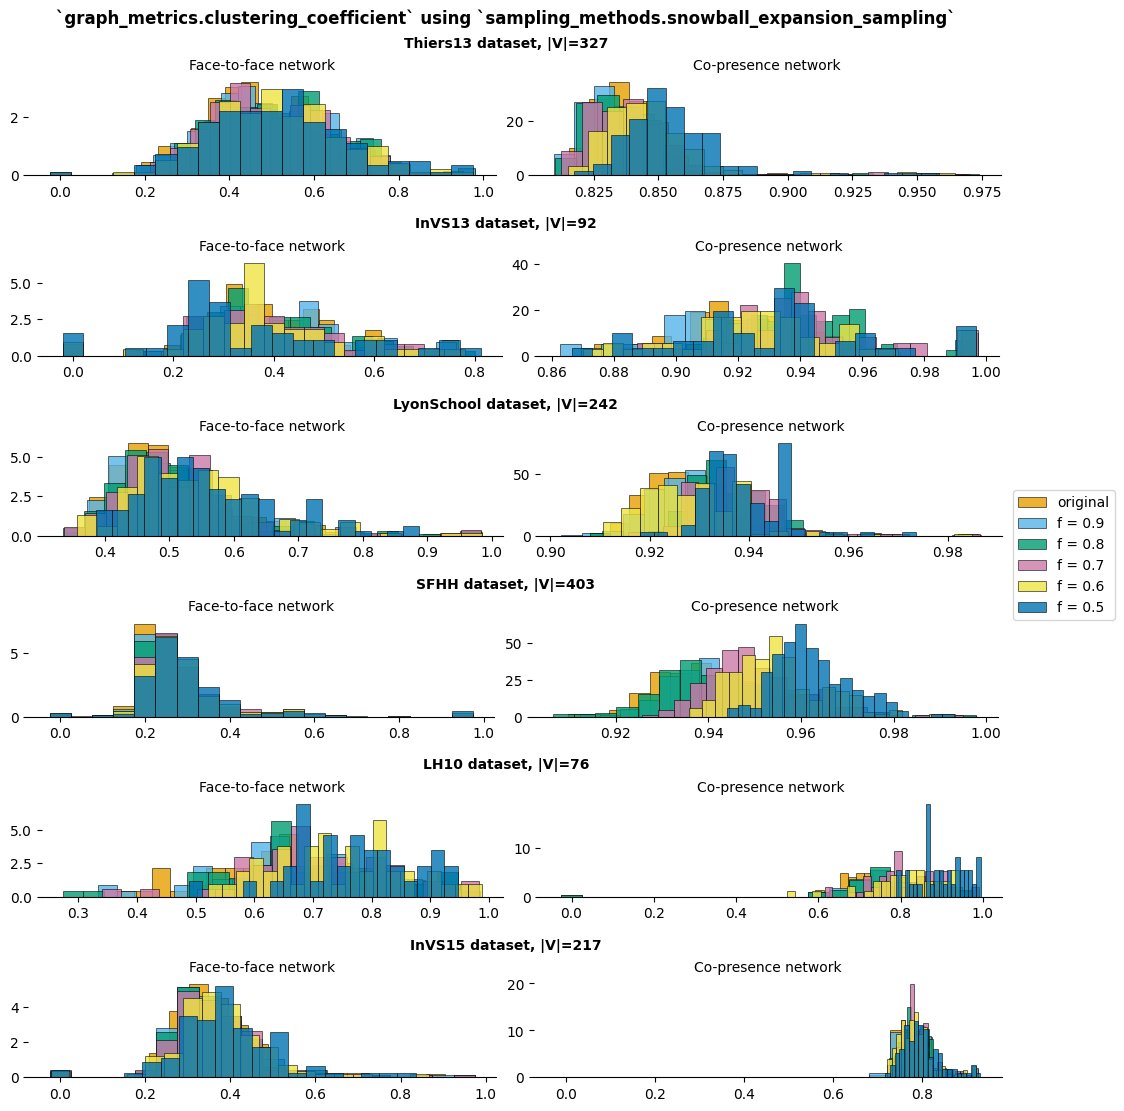

In [18]:
idx = 1
for gm, sm in itertools.product(gms2, sms):
    plot_graph_metric(data=data, 
        graph_metric=gm['gm'],
        sampling_method=sm['sm'],
        sized_by_nodes=sm['sized_by_nodes'],
        sampling_ratios=sampling_ratios, 
        filename=f"proj2_fig{idx}",
        title=f"`{gm['name']}` using `{sm['name']}`")
    idx += 1
    plt.show()